# Modal analysis and steady-state forced response calculation example

Based on the article "Dynamic Torque Analysis of a Wind Turbine Drive Train Including a Direct-Driven Permanent-Magnet Generator" [1].

In [1]:
import numpy as np
import opentorsion as ot

In [2]:
def generator_torque(rpm):
    """
    Generator torque as a function of rotor rotating speed.
    """
    rated_T = 2.9e6

    if rpm < 4:
        torque = 0

    elif rpm < 15:
        m = (0.5 - 0.125) / (15 - 4) * rated_T
        b = 0.5 * rated_T - m * 15

        torque = m * rpm + b

    elif rpm < 22:
        P = rated_T * 15

        torque = P / rpm

    else:
        torque = 0

    return torque

In [3]:
def get_windmill_excitation(rpm):
    """
    Cogging torque and torque ripple as harmonic excitation.
    (Table III in [1])
    """
    f_s = rpm
    vs = np.array([4, 6, 8, 10, 12, 14, 16])
    omegas = 2 * np.pi * vs * f_s

    rated_T = 2.9e6
    amplitudes = np.array(
        [0.0018, 0.0179, 0.0024, 0.0034, 0.0117, 0.0018, 0.0011]
    ) * generator_torque(rpm)
    amplitudes[4] += rated_T * 0.0176

    return omegas, amplitudes

In [4]:
def forced_response():
    """
    First a model of a windmill is created as a system of three lumped masses
    connected by two shafts. The assembly is given harmonic excitation as
    input. Finally, the system response is calculated and plotted.
    """
    # Parameters of the mechanical model
    k1 = 3.67e8  # Nm/rad
    k2 = 5.496e9  # Nm/rad
    J1 = 1e7  # kgm^2
    J2 = 5770  # kgm^2
    J3 = 97030  # kgm^2

    # Creating assembly
    shafts, disks = [], []
    disks.append(ot.Disk(0, J1))
    shafts.append(ot.Shaft(0, 1, None, None, k=k1, I=0))
    disks.append(ot.Disk(1, J2))
    shafts.append(ot.Shaft(1, 2, None, None, k=k2, I=0))
    disks.append(ot.Disk(2, J3))

    assembly = ot.Assembly(shafts, disk_elements=disks)

    M, K = assembly.M, assembly.K  # Mass and stiffness matrices
    C = assembly.C_modal(M, K, xi=0.02)  # Damping matrix

    # Modal analysis
    A, B = assembly.state_matrix(C)
    omegas_undamped, omegas_damped, damping_ratios = assembly.modal_analysis()

    # Print eigenfrequencies.
    # The list contains each eigenfrequency twice: e.g. eigenfrequencies = [1st, 1st, 2nd, 2nd, 3rd, 3rd, ...]
    print("Eigenfrequencies: ", omegas_undamped.round(3))

    # Initiate plotting tools calling Plots(assembly)
    plot_tools = ot.Plots(assembly)

    # Plot eigenmodes, input number of eigenmodes
    plot_tools.plot_assembly()
    plot_tools.plot_eigenmodes(modes=3)
    plot_tools.plot_campbell(frequency_range_rpm=[0, 300], num_modes=2)
    
    # Steady-state forced response analysis
    VT_element1 = []
    VT_element2 = []

    # The excitation depends on the rotational speed of the system.
    # Here the response is calculated at each rotational speed.
    # The responses at each rotational speed are summed to get the total response.
    for rpm in np.linspace(0.1, 25, 5000):
        omegas, amplitudes = get_windmill_excitation(rpm)
        excitations = np.zeros((M.shape[0], omegas.shape[0]), dtype="complex128")
        excitations[2] = amplitudes # Excitation acts on the generator side

        T_vib = assembly.vibratory_torque(excitations, omegas, k_shafts=np.array([k1, k2]), C=C)

        VT_element1.append(np.sum(np.abs(T_vib[0])))
        VT_element2.append(np.sum(np.abs(T_vib[1])))

    T_e = np.array(
        [np.array(VT_element1), np.array(VT_element2)]
    )  # Total response (shaft torque)

    plot_tools = ot.Plots(assembly)
    plot_tools.torque_response_plot(np.linspace(0.1, 25, 5000), T_e, show_plot=True)

    return

Eigenfrequencies:  [   0.       0.      58.34    58.34  1034.115 1034.115]


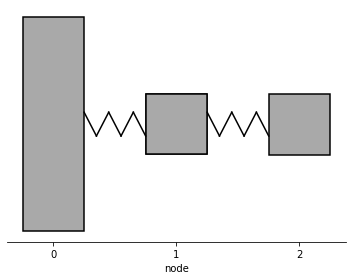

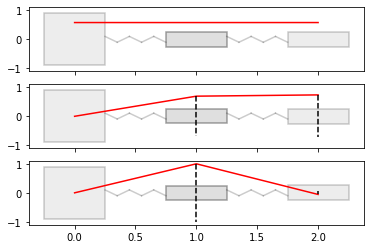

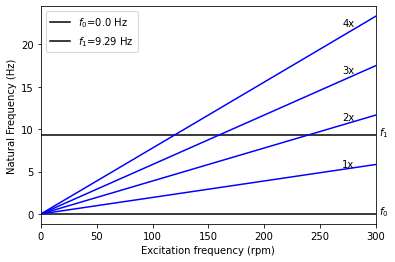

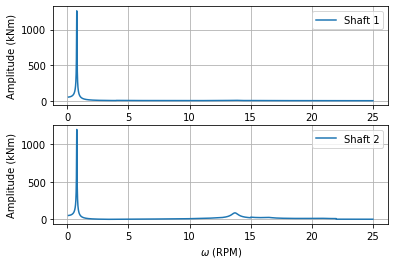

In [5]:
forced_response()

[1] J. Sopanen, V. Ruuskanen, J. Nerg and J. Pyrhonen, “Dynamic Torque Analysis of a Wind Turbine Drive Train Including a Direct-Driven Permanent-Magnet Generator,” in IEEE Transactions on Industrial Electronics, vol. 58, no. 9, pp. 3859-3867, Sept. 2011, https://doi.org/10.1109/TIE.2010.2087301.